In [1]:
# %matplotlib widget
import numpy as np 
import matplotlib.pyplot as plt 
import jax.numpy as jnp 
from jax import jit, random,vmap
from baseline_mppi_obst import MPPI_base
from pi_mppi_obst import pi_mppi
import time

In [2]:
dist = 150
num_obs = 100
num_case = 250

### Upload cases (obstacles and goal points)

goal_location = np.load('./data/goal_loc_data_{}_{}_{}.npy'.format(dist,num_obs,num_case)) # (x,y,z)

obs_x_batch = np.load('./data/obs_x_data_{}_{}_{}.npy'.format(dist,num_obs,num_case))
obs_y_batch = np.load('./data/obs_y_data_{}_{}_{}.npy'.format(dist,num_obs,num_case))
obs_z_batch = np.load('./data/obs_z_data_{}_{}_{}.npy'.format(dist,num_obs,num_case))
obs_r_batch = np.load('./data/obs_r_data_{}_{}_{}.npy'.format(dist,num_obs,num_case))

num_case = 1


In [3]:
num = 100 # number of timesteps
nvar = 11
# Constraints 

v_min = 12.0
v_max = 20.0

vdot_max = 3
vdot_min = -3

vddot_max = 3.0
vddot_min = -3.0

pitch_max = 0.2
pitch_min = -0.2

pitchdot_max = 0.25
pitchdot_min = -0.25

pitchddot_max = 0.15    
pitchddot_min = -0.15

roll_max = 0.25
roll_min = -0.25

rolldot_max = 0.25
rolldot_min = -0.25

rollddot_max = 0.15
rollddot_min = -0.15


In [4]:
# Initial Conditions/obstacles/goal

# Initial states 
x_init = 0
y_init = 0
z_init = 0
psi_init = jnp.pi/1.5

# Initial controls
v_init = 16
pitch_init = 0
roll_init = 0

# Dot init 
vdot_init = 0.
pitchdot_init = 0.
rolldot_init = 0.

In [5]:
# Initialization

mppi_baseline = MPPI_base(num,
                  v_max, v_min, vdot_max, vdot_min, vddot_max,vddot_min,
                    pitch_max,pitch_min, pitchdot_max, pitchdot_min, pitchddot_max, pitchddot_min,
                      roll_max, roll_min, rolldot_max, rolldot_min, rollddot_max, rollddot_min)

mppi_proj = pi_mppi(v_max, v_min, vdot_max, vdot_min, vddot_max,vddot_min,
                    pitch_max,pitch_min, pitchdot_max, pitchdot_min, pitchddot_max, pitchddot_min,
                      roll_max, roll_min, rolldot_max, rolldot_min, rollddot_max, rollddot_min)

In [6]:
# Number of mpc iterations to be run
timesteps = 1000

# Storing values - Baseline
states_base_global = np.zeros((num_case,timesteps,4)) # storing x,y,z,psi 
controls_base = np.zeros((num_case,timesteps,3)) # storing velocity, pitch, roll
dot_base = np.zeros((num_case,timesteps,3))
ddot_base = np.zeros((num_case,timesteps,3))

obs_dist_base = np.zeros((num_case,timesteps,num_obs))

# Storing Values - Projection
states_proj_global = np.zeros((num_case,timesteps,4)) # storing x,y,z,psi 
controls_proj = np.zeros((num_case,timesteps,3)) # storing velocity, pitch, roll
controls_dot_proj = np.zeros((num_case,timesteps,3)) 
controls_ddot_proj = np.zeros((num_case,timesteps,3))

obs_dist_proj = np.zeros((num_case,timesteps,num_obs))

mean_proj_values = np.zeros((num_case,timesteps,33))

# Iterations
iter_left = num_case



In [7]:
start_loc_x = -500
start_loc_y = -700
start_loc_z = 0

x_goal_global = 600
y_goal_global = 500

x_goal_ego = x_goal_global+abs(start_loc_x)
y_goal_ego = y_goal_global+abs(start_loc_y)

In [8]:
for k in range(num_case):

  # Key generation
  key_baseline = random.PRNGKey(0)
  key_proj = random.PRNGKey(0)

  # Goal Location
  x_goal = x_goal_ego
  y_goal = y_goal_ego
  z_goal = 10

  # Obstacles 
  x_obs = obs_x_batch[k,:]
  y_obs = obs_y_batch[k,:]
  z_obs = obs_z_batch[k,:]
  r_obs = obs_r_batch[k,:]


  # Init Base 
  x_init_base_global = start_loc_x
  y_init_base_global = start_loc_y
  z_init_base_global = start_loc_z

  x_goal_base_ego = x_goal
  y_goal_base_ego = y_goal
  z_goal_base_ego = z_goal

  x_obs_base_ego = x_obs
  y_obs_base_ego = y_obs
  z_obs_base_ego = z_obs

  psi_base_init = psi_init
  v_base_init = v_init
  pitch_base_init = pitch_init
  roll_base_init = roll_init

  # Init Proj
  x_init_proj_global = start_loc_x
  y_init_proj_global = start_loc_y
  z_init_proj_global = start_loc_z

  x_goal_proj_ego = x_goal
  y_goal_proj_ego = y_goal
  z_goal_proj_ego = z_goal

  x_obs_proj_ego = x_obs
  y_obs_proj_ego = y_obs
  z_obs_proj_ego = z_obs

  psi_proj_init = psi_init
  v_proj_init = v_init
  pitch_proj_init = pitch_init
  roll_proj_init = roll_init

  # Dot init 
  vdot_base_init = vdot_init
  pitchdot_base_init = pitchdot_init
  rolldot_base_init = rolldot_init 

  # Dot init - Projection MPPI
  vdot_proj_init = vdot_init
  pitchdot_proj_init = pitchdot_init
  rolldot_proj_init = rolldot_init 

  # Initial controls sequence - Baseline MPPI
  v_prev = jnp.ones((num))*v_base_init
  pitch_prev = jnp.ones((num))*pitch_base_init
  roll_prev = jnp.ones((num))*roll_base_init
  u_prev = jnp.hstack((v_prev,pitch_prev,roll_prev))

  # Mean - Projection MPPI
  mean_v_control = jnp.zeros(nvar) 
  mean_pitch_control = jnp.zeros(nvar)
  mean_roll_control = jnp.zeros(nvar) 

  mean_proj = jnp.hstack(( mean_v_control, mean_pitch_control, mean_roll_control  ))


  start = time.time()
  for i in range(timesteps):
      
    #### Baseline MPPI

    states_jax_baseline = jnp.array([x_init_base_global,y_init_base_global,z_init_base_global,psi_base_init])
    states_base_global[k,i,:] = np.asarray(states_jax_baseline)

    key_baseline, init_states_upd_base, init_controls_upd_base, dot_new_base, ddot_new_base, u_prev = mppi_baseline.baseline_mppi_main(u_prev, key_baseline,
                    x_init, y_init, z_init, psi_base_init,
                    v_base_init, pitch_base_init, roll_base_init,
                    x_goal_base_ego,y_goal_base_ego,z_goal_base_ego,
                    x_obs_base_ego, y_obs_base_ego, z_obs_base_ego, r_obs,
                    vdot_base_init, pitchdot_base_init, rolldot_base_init)
    
    # Global location

    x_init_base_global = x_init_base_global + init_states_upd_base[0]
    y_init_base_global = y_init_base_global + init_states_upd_base[1]
    z_init_base_global = z_init_base_global + init_states_upd_base[2]

    # Goal/obs to ego 

    x_goal_base_ego = x_goal_base_ego - init_states_upd_base[0]
    y_goal_base_ego = y_goal_base_ego - init_states_upd_base[1]
    z_goal_base_ego = z_goal_base_ego - init_states_upd_base[2]

    x_obs_base_ego = x_obs_base_ego - init_states_upd_base[0]
    y_obs_base_ego = y_obs_base_ego - init_states_upd_base[1]
    z_obs_base_ego = z_obs_base_ego - init_states_upd_base[2]


    # Update
    psi_base_init = init_states_upd_base[3]

    v_base_init, pitch_base_init, roll_base_init = init_controls_upd_base[0],init_controls_upd_base[1],init_controls_upd_base[2]
    controls_jax_base = jnp.array([v_base_init, pitch_base_init, roll_base_init ])
    vdot_base_init, pitchdot_base_init, rolldot_base_init = dot_new_base[0],dot_new_base[1],dot_new_base[2]

    # Storing controls/dot/ddot,states
    
    controls_base[k,i,:] = np.asarray(controls_jax_base)
    dot_base[k,i,:] = np.asarray(dot_new_base)
    ddot_base[k,i,:] = np.asarray(ddot_new_base)

    # Check if inter. obstacles
    obs_dist_base[k,i,:] = np.asarray(jnp.sqrt((x_init_base_global - x_obs)**2+(y_init_base_global-y_obs)**2+(z_init_base_global-z_obs)**2)-r_obs)

    #### Projected MPPI
    states_jax_proj = jnp.array([x_init_proj_global,y_init_proj_global,z_init_proj_global,psi_proj_init])
    states_proj_global[k,i,:] = np.asarray(states_jax_proj)

    mean_proj,key_proj,init_states_upd_proj,init_controls_upd_proj,controls_dot,controls_ddot = mppi_proj.pi_mppi_main(v_proj_init,
                                                                                              vdot_proj_init, pitch_proj_init,
                                                                                              pitchdot_proj_init, roll_proj_init, rolldot_proj_init,
                                                                                                psi_proj_init,
                                                                                                  x_init, y_init, z_init,
                                                                                                  x_goal_proj_ego, y_goal_proj_ego, z_goal_proj_ego,
                                                                                                    mean_proj,key_proj,
                                                                                                    x_obs_proj_ego,y_obs_proj_ego,z_obs_proj_ego,r_obs)
                                                                        
    # Global location

    x_init_proj_global = x_init_proj_global + init_states_upd_proj[0]
    y_init_proj_global = y_init_proj_global + init_states_upd_proj[1]
    z_init_proj_global = z_init_proj_global + init_states_upd_proj[2]

    # Goal/obs to ego 

    x_goal_proj_ego = x_goal_proj_ego - init_states_upd_proj[0]
    y_goal_proj_ego = y_goal_proj_ego - init_states_upd_proj[1]
    z_goal_proj_ego = z_goal_proj_ego - init_states_upd_proj[2]

    x_obs_proj_ego = x_obs_proj_ego - init_states_upd_proj[0]
    y_obs_proj_ego = y_obs_proj_ego - init_states_upd_proj[1]
    z_obs_proj_ego = z_obs_proj_ego - init_states_upd_proj[2]

    # Update
    psi_proj_init = init_states_upd_proj[3]

    v_proj_init, pitch_proj_init, roll_proj_init = init_controls_upd_proj[0],init_controls_upd_proj[1],init_controls_upd_proj[2]
    # print(controls_dot)
    vdot_proj_init, pitchdot_proj_init, rolldot_proj_init = controls_dot[0],controls_dot[1],controls_dot[2]

    controls_jax_proj = jnp.array([v_proj_init, pitch_proj_init, roll_proj_init ])

    # Storing controls,states
    controls_proj[k,i,:] = np.asarray(controls_jax_proj)
    controls_dot_proj[k,i,:] = np.asarray(controls_dot)
    controls_ddot_proj[k,i,:] = np.asarray(controls_ddot)
    mean_proj_values[k,i,:] = np.asarray(mean_proj)
  
    obs_dist_proj[k,i,:] = np.asarray(jnp.sqrt((x_init_proj_global - x_obs)**2+(y_init_proj_global-y_obs)**2+(z_init_proj_global-z_obs)**2)-r_obs)
  
  iter_left = iter_left - 1


  # print('Cases left: ', iter_left,' Time taken: ',time.time()-start,'s.', 'Intersected obstacle: (Baseline): ',np.any(obs_dist_base[k]<=0,axis=(0,1)))
  # print('Cases left: ', iter_left,' Time taken: ',time.time()-start,'s.','Intersected obstacle: (Proj): ',np.any(obs_dist_proj[k]<=0,axis=(0,1)))

fail_base_cases = (np.any(obs_dist_base<=0,axis = (2,1))).astype(int)

success_base_overall = (num_case - np.sum(fail_base_cases))/num_case * 100

print('Baseline success % :',success_base_overall,'%')

fail_proj_cases = (np.any(obs_dist_proj<=0,axis = (2,1))).astype(int)

success_proj_overall = (num_case - np.sum(fail_proj_cases))/num_case * 100

print('Projection success % :',success_proj_overall,'%')


Baseline success % : 100.0 %
Projection success % : 100.0 %


In [9]:
case_num = 0

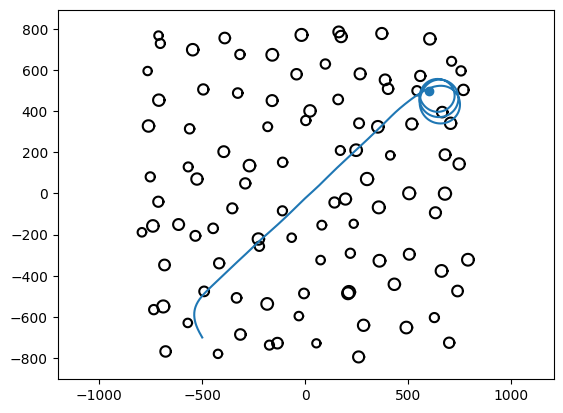

In [10]:
# case_num = 0
plt.figure()
x_obs = obs_x_batch[case_num]
y_obs = obs_y_batch[case_num]
r_obs = obs_r_batch[case_num]

x_goal = x_goal_global
y_goal = y_goal_global
for k in range(len(x_obs)):
    th = jnp.linspace(0, jnp.pi*2, 180)
    x_circ = x_obs[k]+r_obs[k]*jnp.cos(th)
    y_circ = y_obs[k]+r_obs[k]*jnp.sin(th)
    plt.plot(x_circ, y_circ, '-k')
plt.plot(states_base_global[case_num,:,0],states_base_global[case_num,:,1])
plt.scatter(x_goal,y_goal)
plt.axis('equal')
plt.show()

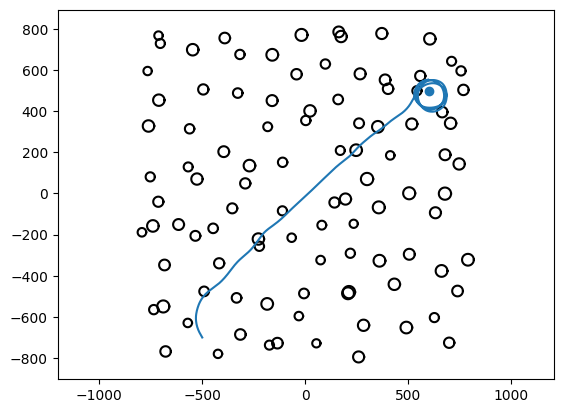

In [11]:
# case_num = 0
plt.figure()
x_obs = obs_x_batch[case_num]
y_obs = obs_y_batch[case_num]
r_obs = obs_r_batch[case_num]

x_goal = x_goal_global
y_goal = y_goal_global
for k in range(len(x_obs)):
    th = jnp.linspace(0, jnp.pi*2, 180)
    x_circ = x_obs[k]+r_obs[k]*jnp.cos(th)
    y_circ = y_obs[k]+r_obs[k]*jnp.sin(th)
    plt.plot(x_circ, y_circ, '-k')
plt.plot(states_proj_global[case_num,:,0],states_proj_global[case_num,:,1])
plt.scatter(x_goal,y_goal)
plt.axis('equal')
plt.show()

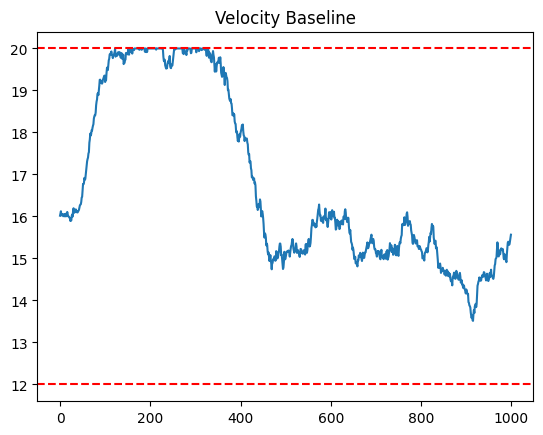

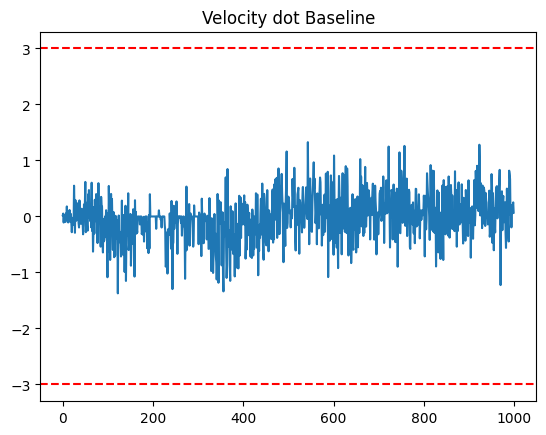

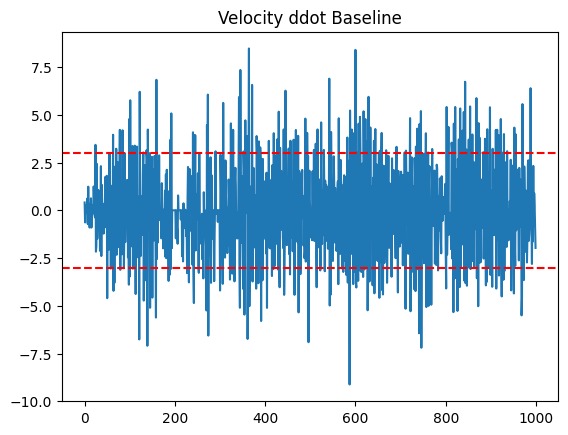

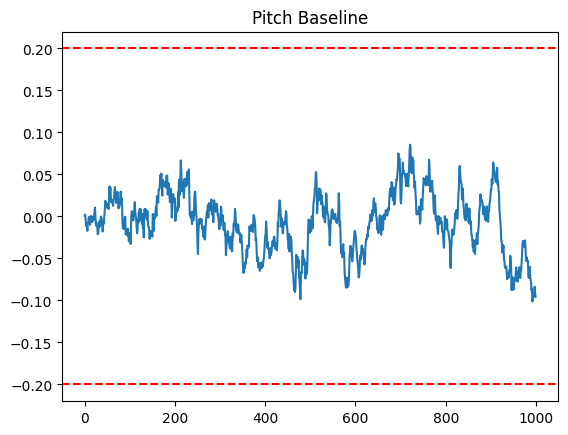

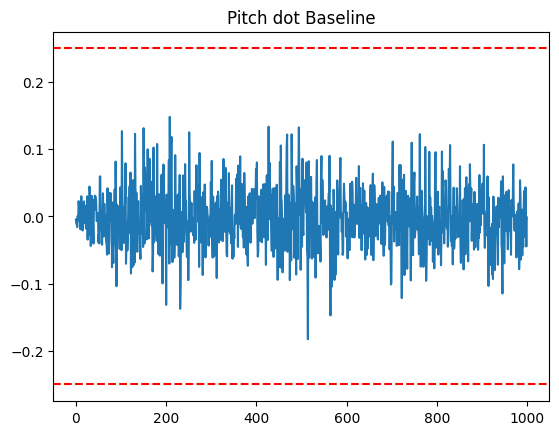

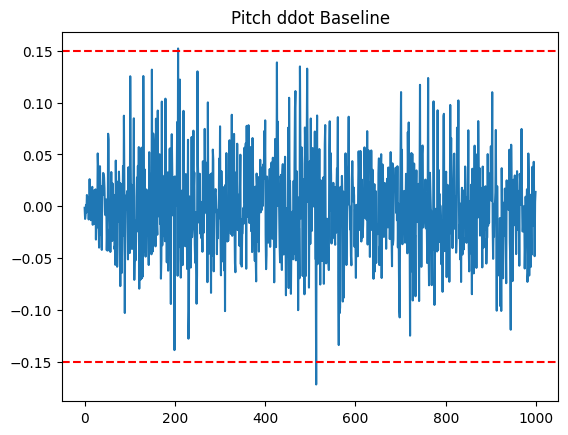

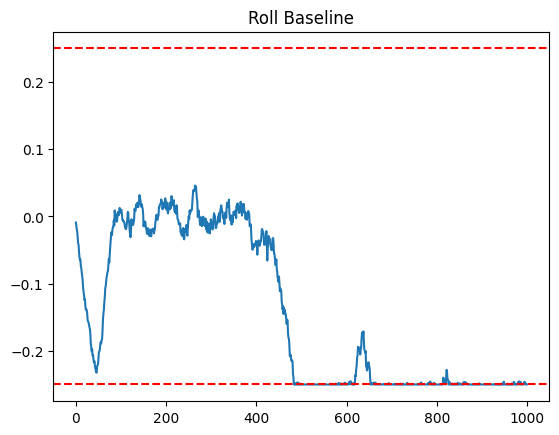

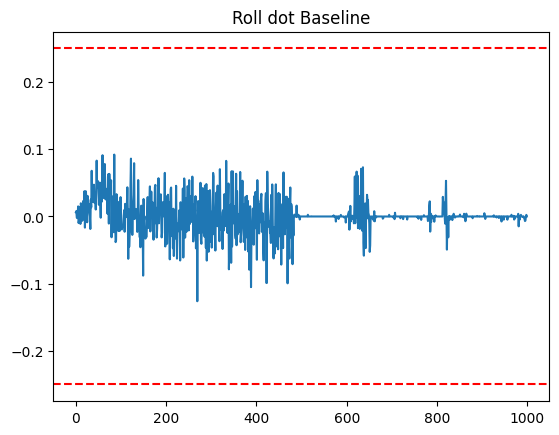

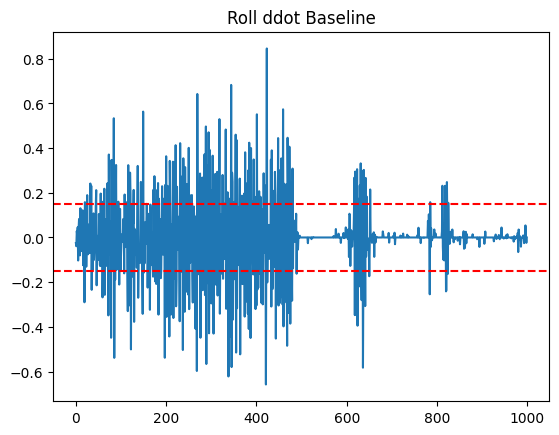

In [12]:
plt.figure(3)
plt.plot(controls_base[:,:,0].T)
plt.axhline(y=v_max, color='red', linestyle='--')
plt.axhline(y=v_min, color='red', linestyle='--')
plt.title('Velocity Baseline')
plt.show()

plt.figure(4)
plt.plot(dot_base[:,:,0].T)
plt.axhline(y=vdot_max, color='red', linestyle='--')
plt.axhline(y=vdot_min, color='red', linestyle='--')
plt.title('Velocity dot Baseline')
plt.show()

plt.figure(5)
plt.plot(ddot_base[:,:,0].T)
plt.axhline(y=vddot_max, color='red', linestyle='--')
plt.axhline(y=vddot_min, color='red', linestyle='--')
plt.title('Velocity ddot Baseline')
plt.show()

plt.figure(6)
plt.plot(controls_base[:,:,1].T)
plt.axhline(y=pitch_max, color='red', linestyle='--')
plt.axhline(y=pitch_min, color='red', linestyle='--')
plt.title('Pitch Baseline')
plt.show()

plt.figure(7)
plt.plot(dot_base[:,:,1].T)
plt.axhline(y=pitchdot_max, color='red', linestyle='--')
plt.axhline(y=pitchdot_min, color='red', linestyle='--')
plt.title('Pitch dot Baseline')
plt.show()

plt.figure(8)
plt.plot(ddot_base[:,:,1].T)
plt.axhline(y=pitchddot_max, color='red', linestyle='--')
plt.axhline(y=pitchddot_min, color='red', linestyle='--')
plt.title('Pitch ddot Baseline')
plt.show()

plt.figure(9)
plt.plot(controls_base[:,:,2].T)
plt.axhline(y=roll_max, color='red', linestyle='--')
plt.axhline(y=roll_min, color='red', linestyle='--')
plt.title('Roll Baseline')
plt.show()

plt.figure(10)
plt.plot(dot_base[:,:,2].T)
plt.axhline(y=rolldot_max, color='red', linestyle='--')
plt.axhline(y=rolldot_min, color='red', linestyle='--')
plt.title('Roll dot Baseline')
plt.show()

plt.figure(11)
plt.plot(ddot_base[:,:,2].T)
plt.axhline(y=rollddot_max, color='red', linestyle='--')
plt.axhline(y=rollddot_min, color='red', linestyle='--')
plt.title('Roll ddot Baseline')
plt.show()


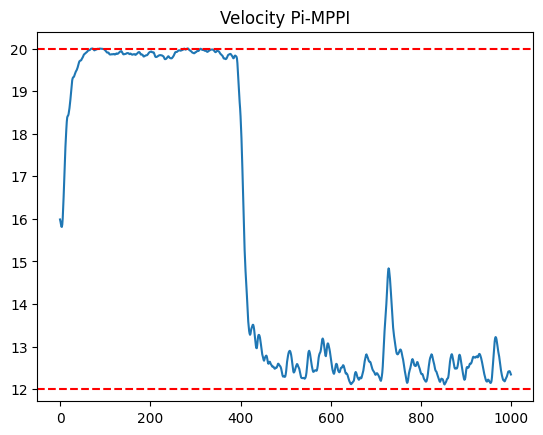

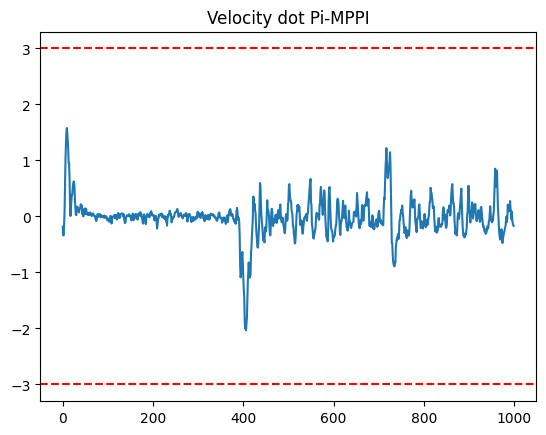

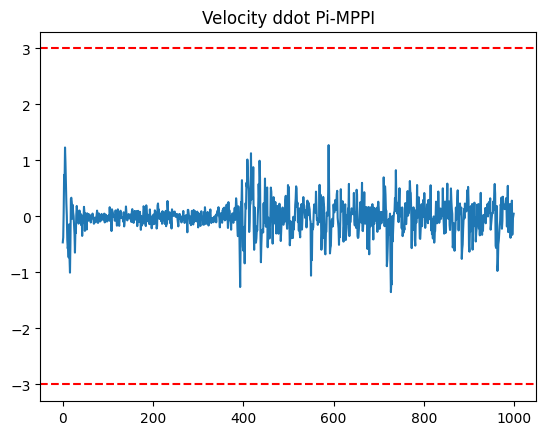

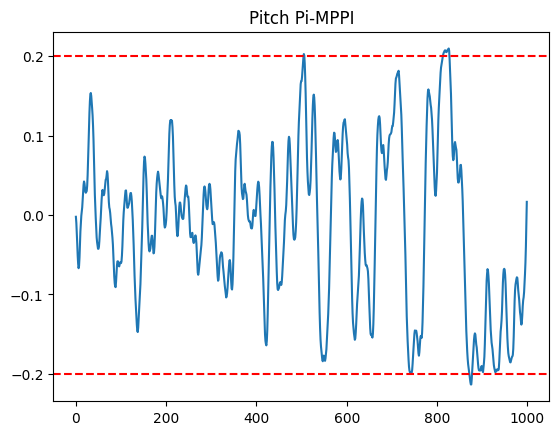

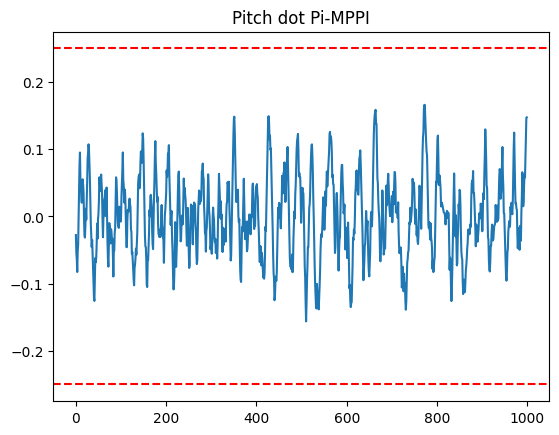

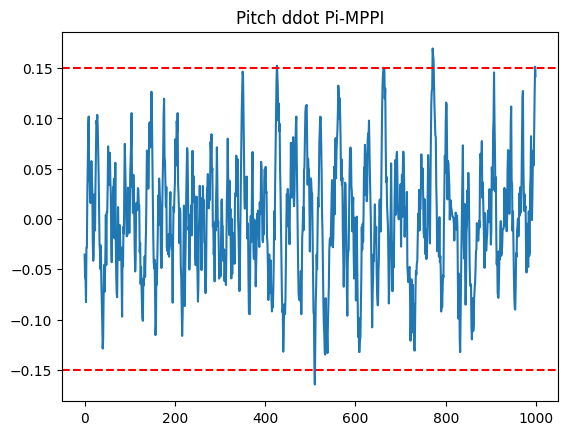

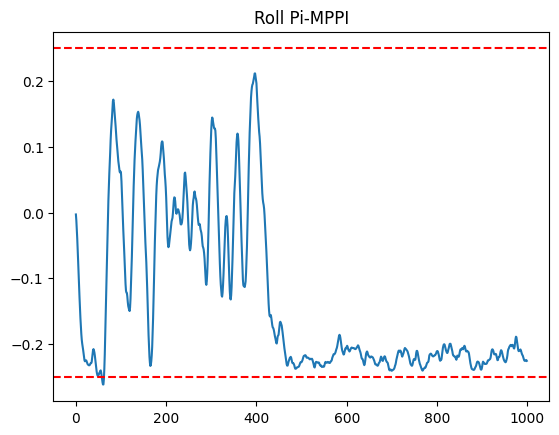

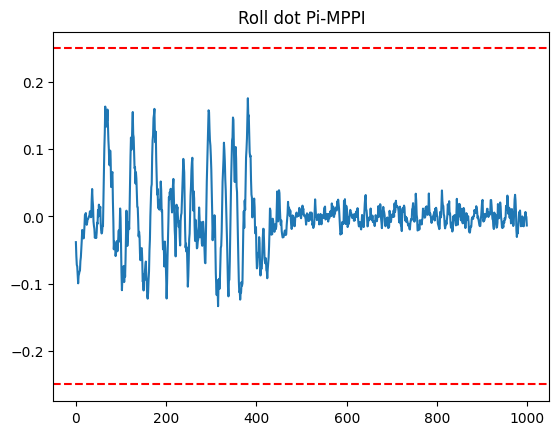

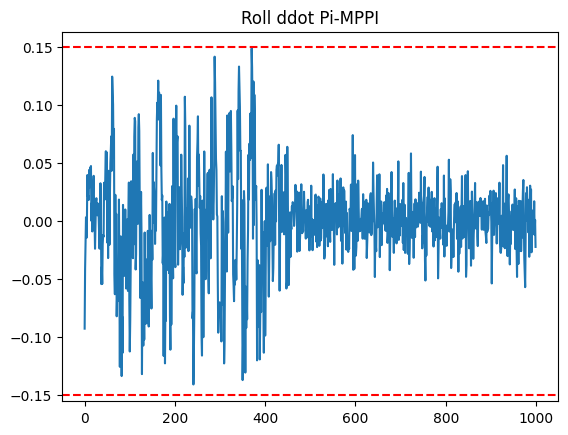

In [13]:
plt.figure()
plt.plot(controls_proj[:,:,0].T)
plt.axhline(y=v_max, color='red', linestyle='--')
plt.axhline(y=v_min, color='red', linestyle='--')
plt.title('Velocity Pi-MPPI')
plt.show()

plt.figure()
plt.plot(controls_dot_proj[:,:,0].T)
plt.axhline(y=vdot_max, color='red', linestyle='--')
plt.axhline(y=vdot_min, color='red', linestyle='--')
plt.title('Velocity dot Pi-MPPI')
plt.show()

plt.figure()
plt.plot(controls_ddot_proj[:,:,0].T)
plt.axhline(y=vddot_max, color='red', linestyle='--')
plt.axhline(y=vddot_min, color='red', linestyle='--')
plt.title('Velocity ddot Pi-MPPI')
plt.show()

plt.figure()
plt.plot(controls_proj[:,:,1].T)
plt.axhline(y=pitch_max, color='red', linestyle='--')
plt.axhline(y=pitch_min, color='red', linestyle='--')
plt.title('Pitch Pi-MPPI')
plt.show()

plt.figure()
plt.plot(controls_dot_proj[:,:,1].T)
plt.axhline(y=pitchdot_max, color='red', linestyle='--')
plt.axhline(y=pitchdot_min, color='red', linestyle='--')
plt.title('Pitch dot Pi-MPPI')
plt.show()

plt.figure()
plt.plot(controls_ddot_proj[:,:,1].T)
plt.axhline(y=pitchddot_max, color='red', linestyle='--')
plt.axhline(y=pitchddot_min, color='red', linestyle='--')
plt.title('Pitch ddot Pi-MPPI')
plt.show()  

plt.figure()
plt.plot(controls_proj[:,:,2].T)
plt.axhline(y=roll_max, color='red', linestyle='--')
plt.axhline(y=roll_min, color='red', linestyle='--')
plt.title('Roll Pi-MPPI')
plt.show()

plt.figure()
plt.plot(controls_dot_proj[:,:,2].T)
plt.axhline(y=rolldot_max, color='red', linestyle='--')
plt.axhline(y=rolldot_min, color='red', linestyle='--')
plt.title('Roll dot Pi-MPPI')
plt.show()

plt.figure()
plt.plot(controls_ddot_proj[:,:,2].T)
plt.axhline(y=rollddot_max, color='red', linestyle='--')
plt.axhline(y=rollddot_min, color='red', linestyle='--')
plt.title('Roll ddot Pi-MPPI')
plt.show()

In [14]:
min_distance_goal_base = np.zeros(num_case)
mean_distance_goal_base = np.zeros(num_case)
for i in range(num_case):
    dist_goal_base = np.sqrt((states_base_global[i,:,0] - goal_location[i,0])**2+(states_base_global[i,:,1]-goal_location[i,1])**2+
    (states_base_global[i,:,2]-goal_location[i,2])**2)
    min_distance_goal_base[i] = np.min(dist_goal_base)
    mean_distance_goal_base[i] = np.mean(dist_goal_base)
mean_min_dist_goal_base = np.mean(min_distance_goal_base)
mean_mean_dist_goal_base = np.mean(mean_distance_goal_base)
print("mean_min_dist_goal_base",mean_min_dist_goal_base)
print("mean_mean_dist_goal_base",mean_mean_dist_goal_base)

min_distance_goal_proj = np.zeros(num_case)
mean_distance_goal_proj = np.zeros(num_case)
for i in range(num_case):
    dist_goal_proj = np.sqrt((states_proj_global[i,:,0] - goal_location[i,0])**2+(states_proj_global[i,:,1]-goal_location[i,1])**2+
    (states_proj_global[i,:,2]-goal_location[i,2])**2)
    min_distance_goal_proj[i] = np.min(dist_goal_proj)
    mean_distance_goal_proj[i] = np.mean(dist_goal_proj)
mean_min_dist_goal_proj = np.mean(min_distance_goal_proj)
mean_mean_dist_goal_proj = np.mean(mean_distance_goal_proj)
print("mean_min_dist_goal_proj",mean_min_dist_goal_proj)
print("mean_mean_dist_goal_proj",mean_mean_dist_goal_proj)

mean_min_dist_goal_base 115.72548422452294
mean_mean_dist_goal_base 589.1914407078114
mean_min_dist_goal_proj 105.78854281143802
mean_mean_dist_goal_proj 571.445833264034


In [15]:
con_viol_vel_base = np.zeros(num_case)
sum_con_viol_vel_base = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_base = np.zeros(timesteps)
    for j in range(timesteps):
        if controls_base[i,j,0]>v_max:
            conviol_vel_base[j] = (controls_base[i,j,0]-v_max)
        elif controls_base[i,j,0]<v_min:
            conviol_vel_base[j] = (v_min-controls_base[i,j,0])
        else:
            pass
    con_viol_vel_base[i] = np.mean(conviol_vel_base)
    sum_con_viol_vel_base[i] = np.sum(conviol_vel_base)
mean_con_viol_vel_base = np.mean(con_viol_vel_base)
tot_con_viol_vel_base = np.sum(sum_con_viol_vel_base)
print("mean_con_viol_vel_base",mean_con_viol_vel_base)
print("tot_con_viol_vel_base",tot_con_viol_vel_base)

con_viol_vel_dot_base = np.zeros(num_case)
sum_con_viol_vel_dot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_dot_base = np.maximum(0,(np.abs(dot_base[i,:,0])-vdot_max))
    con_viol_vel_dot_base[i] = np.mean(conviol_vel_dot_base)
    sum_con_viol_vel_dot_base[i] = np.sum(conviol_vel_dot_base)
mean_con_viol_vel_dot_base = np.mean(con_viol_vel_dot_base)
tot_con_viol_vel_dot_base = np.sum(sum_con_viol_vel_dot_base)
print("mean_con_viol_vel_dot_base",mean_con_viol_vel_dot_base)
print("tot_con_viol_vel_dot_base",tot_con_viol_vel_dot_base)

con_viol_vel_ddot_base = np.zeros(num_case)
sum_con_viol_vel_ddot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_ddot_base = np.maximum(0,(np.abs(ddot_base[i,:,0])-vddot_max))
    con_viol_vel_ddot_base[i] = np.mean(conviol_vel_ddot_base)
    sum_con_viol_vel_ddot_base[i] = np.sum(conviol_vel_ddot_base)
mean_con_viol_vel_ddot_base = np.mean(con_viol_vel_ddot_base)
tot_con_viol_vel_ddot_base = np.sum(sum_con_viol_vel_ddot_base)
print("mean_con_viol_vel_ddot_base",mean_con_viol_vel_ddot_base)
print("tot_con_viol_vel_ddot_base",tot_con_viol_vel_ddot_base)

con_viol_pitch_base = np.zeros(num_case)
sum_con_viol_pitch_base = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_base = np.maximum(0,(np.abs(controls_base[i,:,1])-pitch_max))
    con_viol_pitch_base[i] = np.mean(conviol_pitch_base)
    sum_con_viol_pitch_base[i] = np.sum(conviol_pitch_base)
mean_con_viol_pitch_base = np.mean(con_viol_pitch_base)
tot_con_viol_pitch_base = np.sum(sum_con_viol_pitch_base)
print("mean_con_viol_pitch_base",mean_con_viol_pitch_base)
print("tot_con_viol_pitch_base",tot_con_viol_pitch_base)

con_viol_pitch_dot_base = np.zeros(num_case)
sum_con_viol_pitch_dot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_dot_base = np.maximum(0,(np.abs(dot_base[i,:,1])-pitchdot_max))
    con_viol_pitch_dot_base[i] = np.mean(conviol_pitch_dot_base)
    sum_con_viol_pitch_dot_base[i] = np.sum(conviol_pitch_dot_base)
mean_con_viol_pitch_dot_base = np.mean(con_viol_pitch_dot_base)
tot_con_viol_pitch_dot_base = np.sum(sum_con_viol_pitch_dot_base)
print("mean_con_viol_pitch_dot_base",mean_con_viol_pitch_dot_base)
print("tot_con_viol_pitch_dot_base",tot_con_viol_pitch_dot_base)

con_viol_pitch_ddot_base = np.zeros(num_case)
sum_con_viol_pitch_ddot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_ddot_base = np.maximum(0,(np.abs(ddot_base[i,:,1])-pitchddot_max))
    con_viol_pitch_ddot_base[i] = np.mean(conviol_pitch_ddot_base)
    sum_con_viol_pitch_ddot_base[i] = np.sum(conviol_pitch_ddot_base)
mean_con_viol_pitch_ddot_base = np.mean(con_viol_pitch_ddot_base)
tot_con_viol_pitch_ddot_base = np.sum(sum_con_viol_pitch_ddot_base)
print("mean_con_viol_pitch_ddot_base",mean_con_viol_pitch_ddot_base)
print("tot_con_viol_pitch_ddot_base",tot_con_viol_pitch_ddot_base)


con_viol_roll_base = np.zeros(num_case)
sum_con_viol_roll_base = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_base = np.maximum(0,(np.abs(controls_base[i,:,2])-roll_max))
    con_viol_roll_base[i] = np.mean(conviol_roll_base)
    sum_con_viol_roll_base[i] = np.sum(conviol_roll_base)
mean_con_viol_roll_base = np.mean(con_viol_roll_base)
tot_con_viol_roll_base = np.sum(sum_con_viol_roll_base)
print("mean_con_viol_roll_base",mean_con_viol_roll_base)
print("tot_con_viol_roll_base",tot_con_viol_roll_base)

con_viol_roll_dot_base = np.zeros(num_case)
sum_con_viol_roll_dot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_dot_base = np.maximum(0,(np.abs(dot_base[i,:,2])-rolldot_max))
    con_viol_roll_dot_base[i] = np.mean(conviol_roll_dot_base)
    sum_con_viol_roll_dot_base[i] = np.sum(conviol_roll_dot_base)
mean_con_viol_roll_dot_base = np.mean(con_viol_roll_dot_base)
tot_con_viol_roll_dot_base = np.sum(sum_con_viol_roll_dot_base)
print("mean_con_viol_roll_dot_base",mean_con_viol_roll_dot_base)
print("tot_con_viol_roll_dot_base",tot_con_viol_roll_dot_base)

con_viol_roll_ddot_base = np.zeros(num_case)
sum_con_viol_roll_ddot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_ddot_base = np.maximum(0,(np.abs(ddot_base[i,:,2])-rollddot_max))
    con_viol_roll_ddot_base[i] = np.mean(conviol_roll_ddot_base)
    sum_con_viol_roll_ddot_base[i] = np.sum(conviol_roll_ddot_base)
mean_con_viol_roll_ddot_base = np.mean(con_viol_roll_ddot_base)
tot_con_viol_roll_ddot_base = np.sum(sum_con_viol_roll_ddot_base)
print("mean_con_viol_roll_ddot_base",mean_con_viol_roll_ddot_base)
print("tot_con_viol_roll_ddot_base",tot_con_viol_roll_ddot_base)




con_viol_vel_proj = np.zeros(num_case)
sum_con_viol_vel_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_proj = np.zeros(timesteps)
    for j in range(timesteps):
        if controls_proj[i,j,0]>v_max:
            conviol_vel_proj[j] = (controls_proj[i,j,0]-v_max)
        elif controls_proj[i,j,0]<v_min:
            conviol_vel_proj[j] = (v_min-controls_proj[i,j,0])
        else:pass
    con_viol_vel_proj[i] = np.mean(conviol_vel_proj)
    sum_con_viol_vel_proj[i] = np.sum(conviol_vel_proj)
mean_con_viol_vel_proj = np.mean(con_viol_vel_proj)
tot_con_viol_vel_proj = np.sum(sum_con_viol_vel_proj)
print("\nmean_con_viol_vel_proj",mean_con_viol_vel_proj)
print("tot_con_viol_vel_proj",tot_con_viol_vel_proj)

con_viol_vel_dot_proj = np.zeros(num_case)
sum_con_viol_vel_dot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_dot_proj = np.maximum(0,(np.abs(controls_dot_proj[i,:,0])-vdot_max))
    con_viol_vel_dot_proj[i] = np.mean(conviol_vel_dot_proj)
    sum_con_viol_vel_dot_proj[i] = np.sum(conviol_vel_dot_proj)
mean_con_viol_vel_dot_proj = np.mean(con_viol_vel_dot_proj)
tot_con_viol_vel_dot_proj = np.sum(sum_con_viol_vel_dot_proj)
print("mean_con_viol_vel_dot_proj",mean_con_viol_vel_dot_proj)
print("tot_con_viol_vel_dot_proj",tot_con_viol_vel_dot_proj)

con_viol_vel_ddot_proj = np.zeros(num_case)
sum_con_viol_vel_ddot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_ddot_proj = np.maximum(0,(np.abs(controls_ddot_proj[i,:,0])-vddot_max))
    con_viol_vel_ddot_proj[i] = np.mean(conviol_vel_ddot_proj)
    sum_con_viol_vel_ddot_proj[i] = np.sum(conviol_vel_ddot_proj)
mean_con_viol_vel_ddot_proj = np.mean(con_viol_vel_ddot_proj)
tot_con_viol_vel_ddot_proj = np.sum(sum_con_viol_vel_ddot_proj)
print("mean_con_viol_vel_ddot_proj",mean_con_viol_vel_ddot_proj)
print("tot_con_viol_vel_ddot_proj",tot_con_viol_vel_ddot_proj)

con_viol_pitch_proj = np.zeros(num_case)
sum_con_viol_pitch_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_proj = np.maximum(0,(np.abs(controls_proj[i,:,1])-pitch_max))
    con_viol_pitch_proj[i] = np.mean(conviol_pitch_proj)
    sum_con_viol_pitch_proj[i] = np.sum(conviol_pitch_proj)
mean_con_viol_pitch_proj = np.mean(con_viol_pitch_proj)
tot_con_viol_pitch_proj = np.sum(sum_con_viol_pitch_proj)
print("mean_con_viol_pitch_proj",mean_con_viol_pitch_proj)
print("tot_con_viol_pitch_proj",tot_con_viol_pitch_proj)

con_viol_pitch_dot_proj = np.zeros(num_case)
sum_con_viol_pitch_dot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_dot_proj = np.maximum(0,(np.abs(controls_dot_proj[i,:,1])-pitchdot_max))
    con_viol_pitch_dot_proj[i] = np.mean(conviol_pitch_dot_proj)
    sum_con_viol_pitch_dot_proj[i] = np.sum(conviol_pitch_dot_proj)
mean_con_viol_pitch_dot_proj = np.mean(con_viol_pitch_dot_proj)
tot_con_viol_pitch_dot_proj = np.sum(sum_con_viol_pitch_dot_proj)
print("mean_con_viol_pitch_dot_proj",mean_con_viol_pitch_dot_proj)
print("tot_con_viol_pitch_dot_proj",tot_con_viol_pitch_dot_proj)

con_viol_pitch_ddot_proj = np.zeros(num_case)
sum_con_viol_pitch_ddot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_ddot_proj = np.maximum(0,(np.abs(controls_ddot_proj[i,:,1])-pitchddot_max))
    con_viol_pitch_ddot_proj[i] = np.mean(conviol_pitch_ddot_proj)
    sum_con_viol_pitch_ddot_proj[i] = np.sum(conviol_pitch_ddot_proj)
mean_con_viol_pitch_ddot_proj = np.mean(con_viol_pitch_ddot_proj)
tot_con_viol_pitch_ddot_proj = np.sum(sum_con_viol_pitch_ddot_proj)
print("mean_con_viol_pitch_ddot_proj",mean_con_viol_pitch_ddot_proj)
print("tot_con_viol_pitch_ddot_proj",tot_con_viol_pitch_ddot_proj)


con_viol_roll_proj = np.zeros(num_case)
sum_con_viol_roll_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_proj = np.maximum(0,(np.abs(controls_proj[i,:,2])-roll_max))
    con_viol_roll_proj[i] = np.mean(conviol_roll_proj)
    sum_con_viol_roll_proj[i] = np.sum(conviol_roll_proj)
mean_con_viol_roll_proj = np.mean(con_viol_roll_proj)
tot_con_viol_roll_proj = np.sum(sum_con_viol_roll_proj)
print("mean_con_viol_roll_proj",mean_con_viol_roll_proj)
print("tot_con_viol_roll_proj",tot_con_viol_roll_proj)

con_viol_roll_dot_proj = np.zeros(num_case)
sum_con_viol_roll_dot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_dot_proj = np.maximum(0,(np.abs(controls_dot_proj[i,:,2])-rolldot_max))
    con_viol_roll_dot_proj[i] = np.mean(conviol_roll_dot_proj)
    sum_con_viol_roll_dot_proj[i] = np.sum(conviol_roll_dot_proj)
mean_con_viol_roll_dot_proj = np.mean(con_viol_roll_dot_proj)
tot_con_viol_roll_dot_proj = np.sum(sum_con_viol_roll_dot_proj)
print("mean_con_viol_roll_dot_proj",mean_con_viol_roll_dot_proj)
print("tot_con_viol_roll_dot_proj",tot_con_viol_roll_dot_proj)

con_viol_roll_ddot_proj = np.zeros(num_case)
sum_con_viol_roll_ddot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_ddot_proj = np.maximum(0,(np.abs(controls_ddot_proj[i,:,2])-rollddot_max))
    con_viol_roll_ddot_proj[i] = np.mean(conviol_roll_ddot_proj)
    sum_con_viol_roll_ddot_proj[i] = np.sum(conviol_roll_ddot_proj)
mean_con_viol_roll_ddot_proj = np.mean(con_viol_roll_ddot_proj)
tot_con_viol_roll_ddot_proj = np.sum(sum_con_viol_roll_ddot_proj)
print("mean_con_viol_roll_ddot_proj",mean_con_viol_roll_ddot_proj)
print("tot_con_viol_roll_ddot_proj",tot_con_viol_roll_ddot_proj)


mean_con_viol_vel_base 0.0
tot_con_viol_vel_base 0.0
mean_con_viol_vel_dot_base 0.0
tot_con_viol_vel_dot_base 0.0
mean_con_viol_vel_ddot_base 0.3118123922348022
tot_con_viol_vel_ddot_base 311.81239223480225
mean_con_viol_pitch_base 0.0
tot_con_viol_pitch_base 0.0
mean_con_viol_pitch_dot_base 0.0
tot_con_viol_pitch_dot_base 0.0
mean_con_viol_pitch_ddot_base 2.4242517352104197e-05
tot_con_viol_pitch_ddot_base 0.024242517352104198
mean_con_viol_roll_base 0.0
tot_con_viol_roll_base 0.0
mean_con_viol_roll_dot_base 0.0
tot_con_viol_roll_dot_base 0.0
mean_con_viol_roll_ddot_base 0.03686927418410778
tot_con_viol_roll_ddot_base 36.86927418410778

mean_con_viol_vel_proj 1.5048980712890626e-06
tot_con_viol_vel_proj 0.0015048980712890625
mean_con_viol_vel_dot_proj 0.0
tot_con_viol_vel_dot_proj 0.0
mean_con_viol_vel_ddot_proj 0.0
tot_con_viol_vel_ddot_proj 0.0
mean_con_viol_pitch_proj 0.000143705880641937
tot_con_viol_pitch_proj 0.143705880641937
mean_con_viol_pitch_dot_proj 0.0
tot_con_viol_pitch_